In [149]:
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt

In [173]:
#Import and cleanse data
fileName = 'OriginalDataSet.csv'  #Can't be made public since it included customers' trades
df = pd.read_csv(fileName, dtype = 'str')
df.dropna(how='all', axis=1, inplace=True)
df.drop(cols_to_drop, axis=1, inplace=True)
delCols = ['ClOrdID', 'OrigClOrdID', 'SubmitTime', 'ExecID', 'CumFee', \
           'SubAccount', 'Strategy', 'OrdType', 'Revision', 'LastRequestTimestamp', 'Text', \
          'Parameters', 'Allocation']
df.drop(delCols, axis=1, inplace=True)
df['Timestamp'] = pd.to_datetime(df['TransactTime'])
df[['Group', 'Parent']] = df['Group'].str.split('/', 1, expand=True)
df[['Parent', 'LastInChain']] = df['Parent'].str.split('/', 1, expand=True)

In [174]:
#Choose BTC for vol calculations
df = df.loc[df['Symbol.1'] == 'BTC']

In [175]:
#Dict for parentID groups
chainDict = {}
for ind in df.index:
    parentID = df.loc[ind]['Parent']
    if parentID == None:
        continue
    if parentID in chainDict.keys():
        chainDict[parentID].append(ind)
    else:
        chainDict[parentID] = [ind]

In [176]:
#Add parent to parentID group
for ind in df.index:
    orderID = df.loc[ind]['OrderID']
    if orderID in chainDict.keys():
        chainDict[orderID].append(ind)

## Using time-weighted arithmetic mean

In [177]:
def normTimeMean(df, chainDict):
    #Parse through each order chain and calculate annnualized captured vol
    secInYear = 365*24*60*60
    capVol = []
    qty = []
    for key in chainDict.keys():
        #Data cleanse
        chain = df.loc[chainDict[key]][['Timestamp', 'Side', 'CumQty', 'AvgPxAllIn', 'Parent']]
        chain = chain.sort_values(by='Timestamp',ascending=True)
        chain['AvgPxAllIn'] = chain['AvgPxAllIn'].astype('float')
        chain['CumQty'] = chain['CumQty'].astype('float')

        #Captured vol calculations
        chain['tDelta'] = chain['Timestamp'].diff()/np.timedelta64(1, 's')/secInYear
        chain['logReturns'] = np.log(chain.AvgPxAllIn) - np.log(chain.AvgPxAllIn.shift(1))
        totalTime = chain.tDelta.sum()
        chain['TWM'] = chain.logReturns*(chain.tDelta/totalTime)
        TWM = chain.TWM.sum()
        chain['dev2'] = (chain.logReturns - TWM)**2
        stdDev = np.sqrt(chain.dev2.mean())
        annualizedCapturedVol = stdDev*np.sqrt(1/totalTime)
        #Store captured vol and orderqty for weighted captured vol calc
        capVol.append(annualizedCapturedVol)
        qty.append(chain.CumQty.mean())
    return [capVol, qty]

## Using root time weighted arithmetic mean

In [178]:
def rootTimeMean(df, chainDict):   
    #Parse through each order chain and calculate annnualized captured vol
    secInYear = 365*24*60*60
    capVol = []
    qty = []
    time = []
    for key in chainDict.keys():
        #Data cleanse
        chain = df.loc[chainDict[key]][['Timestamp', 'Side', 'CumQty', 'AvgPxAllIn', 'Parent']]
        chain = chain.sort_values(by='Timestamp',ascending=True)
        chain['AvgPxAllIn'] = chain['AvgPxAllIn'].astype('float')
        chain['CumQty'] = chain['CumQty'].astype('float')
        
        #Captured vol calculations
        time.append(chain.iloc[-1].Timestamp)
        chain['tDelta'] = np.sqrt(chain['Timestamp'].diff()/np.timedelta64(1, 's')/secInYear)
        chain['logReturns'] = np.log(chain.AvgPxAllIn) - np.log(chain.AvgPxAllIn.shift(1))
        totalTime = chain.tDelta.sum()
        chain['TWM'] = chain.logReturns*(chain.tDelta/totalTime)
        TWM = chain.TWM.sum()
        chain['dev2'] = (chain.logReturns - TWM)**2
        stdDev = np.sqrt(chain.dev2.mean())
        chain['tDelta'] = chain['Timestamp'].diff()/np.timedelta64(1, 's')/secInYear
        totalTime = chain.tDelta.sum()
        annualizedCapturedVol = stdDev*np.sqrt(1/totalTime)
        #Store captured vol and orderqty for weighted captured vol calc
        capVol.append(annualizedCapturedVol)
        qty.append(chain.CumQty.mean())
    return [capVol, qty, time]

## Include short chains

In [179]:
def newRootTimeMean(df, chainDict):   
    #Parse through each order chain and calculate annnualized captured vol
    secInYear = 365*24*60*60
    for key in chainDict.keys():
        #Data cleanse
        chain = df.loc[chainDict[key]][['Timestamp', 'Side', 'CumQty', 'AvgPxAllIn', 'Parent']]
        chain = chain.sort_values(by='Timestamp',ascending=True)
        chain['AvgPxAllIn'] = chain['AvgPxAllIn'].astype('float')
        chain['CumQty'] = chain['CumQty'].astype('float')
        
        if len(chain.index) < 2:
            time.append(chain.iloc[-1].Timestamp)
            capVol.append(0)
            qty.append(chain.CumQty.mean())
            continue
            
        #Captured vol calculations
        time.append(chain.iloc[-1].Timestamp)
        chain['tDeltaSqrt'] = np.sqrt(chain['Timestamp'].diff()/np.timedelta64(1, 's')/secInYear)
        chain['logReturns'] = np.log(chain.AvgPxAllIn) - np.log(chain.AvgPxAllIn.shift(1))
        totalTimeSqrt = chain.tDeltaSqrt.sum()
        chain['TWM'] = chain.logReturns*(chain.tDelta/totalTime)
        TWM = chain.TWM.sum()
        chain['dev2'] = (chain.logReturns - TWM)**2
        stdDev = np.sqrt(chain.dev2.mean())
        chain['tDelta'] = chain['Timestamp'].diff()/np.timedelta64(1, 's')/secInYear
        totalTime = chain.tDelta.sum()
        annualizedCapturedVol = stdDev*np.sqrt(1/totalTime)
        #Store captured vol and orderqty for weighted captured vol calc
        capVol.append(annualizedCapturedVol)
        qty.append(chain.CumQty.mean())
    return [capVol, time]

## Final Captured Vol Equation

In [183]:
def capturedVol(df, chainDict):
    #Parse through each order chain and calculate log returns
    secInYear = 365*24*60*60
    returnsData = pd.DataFrame(columns = ['range', 'tDelta'])
    for key in chainDict.keys():
        #Data cleanse
        chain = []
        #print(chainDict[key])
        chain = df.loc[chainDict[key]][['Timestamp', 'Price', 'User']]
        #print(chain)
        chain = chain.sort_values(by='Timestamp',ascending=True)
        chain['Price'] = chain['Price'].astype('float')
        
        #print(chain) 
        if len(chain.index) < 2:
            continue
        
        chain['range'] = (np.log(chain.Price) - np.log(chain.Price.shift(1)))/np.sqrt((chain.Timestamp - chain.Timestamp.shift(1))/np.timedelta64(1, 's')/secInYear)
        chain['tDelta'] = np.sqrt((chain.Timestamp - chain.Timestamp.shift(1))/np.timedelta64(1, 's')/secInYear)
        #print(chain)
        chain = chain[['range', 'tDelta']].dropna()
        
        
        #print(chain)
        returnsData = pd.concat([returnsData, chain])
        #print(len(returnsData))

    capVol = (returnsData['range'].std())/np.sqrt(365/returnsData['tDelta'].sum())
    
    return capVol, returnsData

## Final Mean Calc

In [184]:
capVol, returnsData = capturedVol(df, chainDict)
print("Mean annualized captured volatility: " + str(round(capVol*100, 3)) + "%")

Mean annualized captured volatility: 18.889%


In [182]:
df

,Timestamp,User,Symbol,OrderID,Side,TransactTime,OrderQty,Price,Symbol.1,CumQty,AvgPx,CumAmt,AvgPxAllIn,Group,Parent,LastInChain
20,2022-06-08 14:30:19.069000+00:00,Contingent-API,ftx:BTC-PERP,74089028-b2af-4649-bb07-4a2aa33f1c69,Buy,2022-06-08T14:30:19.069000Z,29.68013,30454.31944621463,BTC,29.6801,30452.62287526,903836.8922,30452.76983346,contingent,1a73f116-a513-477e-a095-b911eb4a8485,1a73f116-a513-477e-a095-b911eb4a8485
25,2022-06-08 13:35:08.238000+00:00,Contingent-API,ftx:BTC-PERP,b7839b51-84f0-42dd-a63d-8802bc64c12b,Sell,2022-06-08T13:35:08.238000Z,15.14955,30422.89033762416,BTC,15.1495,30425.10310571,460925.0995,30423.84974501,contingent,5420e731-cdb0-44c8-8e7a-fd1cff21f2f4,5420e731-cdb0-44c8-8e7a-fd1cff21f2f4
37,2022-06-08 13:49:32.180000+00:00,Contingent-Yuan-API,ftx:BTC-PERP,1a73f116-a513-477e-a095-b911eb4a8485,Sell,2022-06-08T13:49:32.180000Z,29.68013,30700.6799,BTC,29.6801,30730.89752393,912096.1116,30728.47127231,Contingent(90.0bps),None,None
38,2022-06-08 12:26:00.546000+00:00,Contingent-Yuan-API,ftx:BTC-PERP,5420e731-cdb0-44c8-8e7a-fd1cff21f2f4,Buy,2022-06-08T12:26:00.546000Z,15.14955,30152.9968,BTC,15.1495,30151.52659824,456780.5522,30151.84825073,Contingent(90.0bps),None,None
120,2022-06-07 14:37:32.307000+00:00,Contingent-Yuan-API,ftx:BTC-PERP,ccda9ad5-7c4e-427d-a408-6f8fe38e5cca,Sell,2022-06-07T14:37:32.307000Z,45.608365,29852.1215,BTC,45.6083,29853.29178022,1361557.8875,29852.34993836,Contingent(90.0bps),None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40485,2022-03-19 02:23:46.137000+00:00,Contingent-API,ftx:BTC-PERP,5057664a-d040-4369-80a0-491276a9bdb8,Buy,2022-03-19T02:23:46.137000Z,9.0510,41684,BTC,1.3773,41684,57411.3732,41680.66528,contingent,bda00947-ddaa-44d1-8a1b-837a72d17697,556665a5-14f4-4bc0-a499-9bab15e3bf3c
40544,2022-03-18 23:37:56.085000+00:00,Contingent-API,ftx:BTC-PERP,556665a5-14f4-4bc0-a499-9bab15e3bf3c,Sell,2022-03-18T23:37:56.085000Z,9.0510,41888,BTC,9.0510,41888.20119324,379130.109,41888.30459879,contingent,bda00947-ddaa-44d1-8a1b-837a72d17697,bda00947-ddaa-44d1-8a1b-837a72d17697
40573,2022-03-19 00:34:06.348000+00:00,Contingent-API,ftx:BTC-PERP,fa674061-6064-46d3-81cb-293e6917a2e9,Sell,2022-03-19T00:34:06.348000Z,9.0999,41934,BTC,9.0999,41936.15552918,381614.8217,41933.97532816,contingent,70459796-b35f-41a5-bdc3-5438ca401d02,70459796-b35f-41a5-bdc3-5438ca401d02
40596,2022-03-18 22:04:30.529000+00:00,Contingent-API,ftx:BTC-PERP,77c0b700-0eae-4855-bfd1-388905d79c14,Buy,2022-03-18T22:04:30.529000Z,9.0999,41810,BTC,9.0999,41807.83121793,380447.0833,41813.04564473,contingent,00a5353d-cbac-49a2-b304-e688d5ea3987,45815b58-bf37-429c-943e-a3b796a9ac4c


## Spot price data cleanse

In [10]:
spotPrice = df[['Timestamp', 'Price']]
spotPrice.loc[:,'Price'] = spotPrice['Price'].astype('float')
spotPrice = spotPrice.sort_values(by='Timestamp',ascending=False)


C:\Users\TBaker\AppData\Local\Temp\ipykernel_11636\3626861056.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spotPrice.loc[:,'Price'] = spotPrice['Price'].astype('float')


## Rolling volatility calculations

In [11]:
rv = pd.DataFrame({'time':time, 'capVol':capVol, 'qty':qty})
rv = rv.sort_values(by='time',ascending=True)
rolQty = rv.qty.values
capVols = rv.capVol.values

rollingVol = []
for i in range(1, len(qty)+1):
    vols = capVols[0:i+1]
    counts = rolQty[0:i+1]
    rollingVol.append(np.average(vols, weights = counts))


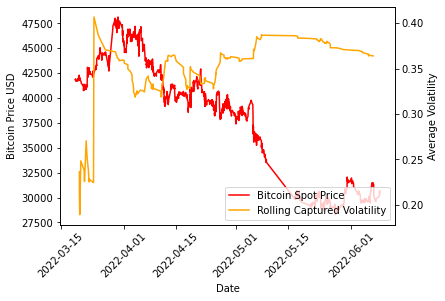

In [12]:
# Plot spot price and rolling volatility data
ax1 = plt.subplot()
l1, = ax1.plot(spotPrice.Timestamp, spotPrice.Price, color='red')
ax2 = ax1.twinx()
l2, = ax2.plot(rv.time, rollingVol, color='orange')
plt.legend([l1, l2], ["Bitcoin Spot Price", "Rolling Captured Volatility"])
ax1.set_ylabel("Bitcoin Price USD")
ax1.set_xlabel("Date")
ax2.set_ylabel("Average Volatility")
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
plt.show()

## Captured Vol as Function of BPS

In [13]:
# Function for grouping order chains based on their bps
def getBpsDict(bps):
    bpsDict = {}
    for key in chainDict.keys():
        #Data cleanse
        cont = df.loc[chainDict[key]][['Group']].iloc[-1][0]
        if cont == "contingent":
            continue
        bpsParent = int(cont.split('(')[1][0:2])
        if bps == bpsParent:
            bpsDict[key] = chainDict[key]
    return bpsDict

In [14]:
# Left out 95 bps as there's not enough order chains to create reliable captured vol numbers
bpsList = [50, 65, 75, 85, 90]
capVolList = []
for bps in bpsList:
    bpsDict = getBpsDict(bps)
    [capVol, qty] = normTimeMean(df, bpsDict)
    capVolList.append(np.average(capVol, weights = qty))

print(bpsList, capVolList)

[50, 65, 75, 85, 90] [0.190568796352924, 0.3805174284335034, 0.43854704541774076, 0.40853229457062706, 0.35269985743140736]


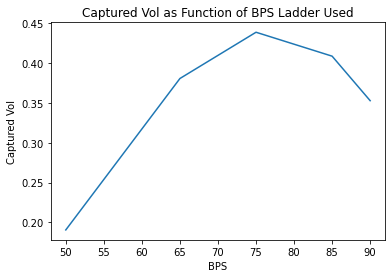

In [15]:
plt.title("Captured Vol as Function of BPS Ladder Used") 
plt.xlabel("BPS") 
plt.ylabel("Captured Vol") 
plt.plot(bpsList,capVolList) 
plt.show()

In [16]:
capVol = pd.DataFrame({'time': rv.time, 'rollingCapVol': rollingVol})

In [17]:
rv.to_csv('rollingCapturedVol.csv')

In [18]:
len(parentDict.keys())

527

In [19]:
len(chainDict.keys())

256

In [35]:
parentDict.keys()

dict_keys(['00280199-7535-402c-8fc7-d3d4b495d6d6', '00a5353d-cbac-49a2-b304-e688d5ea3987', '02ae2476-9b9a-46d6-9a63-3e45e660872a', '02fc9745-691e-4e33-b022-3690c7af71f7', '03279f36-5e3e-4c72-b4f3-9d00c8626225', '0328b97d-d79d-4047-9b88-fd274b71207d', '04b5e824-69bc-4de6-bde8-c470a99f06f9', '05370791-1484-4663-8647-8464d8b50d8e', '0555a9ad-fdd0-49d4-98f1-53d2e72feea8', '05b69563-4646-4161-943d-b0c7361cd11e', '060d29af-d333-46a8-a7fc-5d4b95217859', '0615da97-a66b-4590-bcaf-51de6ae0017e', '06365817-7fe1-4f4d-ae28-f84a3954ecb6', '0680b8ab-40b0-4f07-bebd-c30f1a6e1afe', '06b080fc-0067-450c-b654-692e171d1dfd', '07233fde-dbe3-477c-a97e-57123c756c66', '077763b6-1c95-46f4-8345-66552588484b', '07bb2295-c728-40db-8d81-e620a254022f', '08379094-b564-4da8-9b82-90d857b468fe', '087fb4d0-9062-4282-9152-874015d3bee3', '08b6b783-df02-40a8-81dd-ee3c1697665f', '08e60fa7-2068-4f5b-9567-8275febb2510', '09354ce1-2063-454c-9804-6ea09a568f38', '09ebab73-43b4-452b-a73a-07326835271f', '0a25c502-3fcc-4ed3-a829-b33b